<a href="https://colab.research.google.com/github/ayphilly/Neural-Net-ML/blob/main/denoise_CNA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [ ]:
!pip install idx2numpy

  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7903 sha256=2d3dc235c7777d353fa79c1517b779637b291ef20f1e7d41612c7b508eed07b2
  Stored in directory: /root/.cache/pip/wheels/f7/48/00/ae031c97d62f39e1c3c4daa00426c09a65eb29ae5753a189ee
Successfully built idx2numpy


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import idx2numpy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,UpSampling2D,concatenate, BatchNormalization, Activation

In [ ]:
def add_gaussian_noise(images, mean=0.0, std=0.1):
    noise = np.random.normal(loc=0.0, scale=std, size=images.shape)
    noisy_images = images + noise

    # clip so it doesnt exceed min 0 or max 1 for normilaztion
    noisy_images = np.clip(noisy_images, 0., 1.)
    return noisy_images

In [ ]:
# !pip uninstall tensorflow -y

In [ ]:
def add_salt_and_pepper_noise(image, amount=0.05):
    noisy_image = np.copy(image)

    # Salt noise (1)
    num_salt = np.ceil(amount * image.size * 0.5)
    coords = [np.random.randint(0, max(1, i - 1), int(num_salt)) for i in image.shape]
    noisy_image[tuple(coords)] = 1.0

    # Pepper noise (0)
    num_pepper = np.ceil(amount * image.size * 0.5)
    coords = [np.random.randint(0, max(1, i - 1), int(num_pepper)) for i in image.shape]
    noisy_image[tuple(coords)] = 0.0
    return noisy_image

In [ ]:
def add_speckle_noise(image, variance=0.05):
    noise = np.random.randn(*image.shape) * np.sqrt(variance)
    noisy_image = image + image * noise
    noisy_image = np.clip(noisy_image, 0.0, 1.0)
    return noisy_image

In [ ]:
# Load MNIST dataset
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
print("Training data shape:", x_train_mnist.shape)
print("Test data shape:", x_test_mnist.shape)

Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)


In [ ]:
def showImages (images, rng=5):
    for i in range (5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i], cmap="gray")
        # plt.title(f"Label: {y_train_mnist[i]}")
        plt.axis("off")


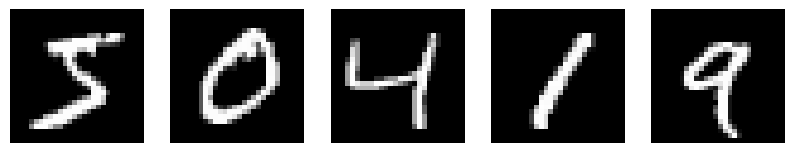

In [ ]:
plt.figure(figsize=(10, 2))
showImages(x_train_mnist)
plt.show()

In [ ]:
def normImages (x_train, x_test):
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    return x_train, x_test

def reshapeImages (x_train, x_test):
    x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
    x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
    return x_train, x_test

In [ ]:
# normalize & reshape mnist
# note: do not run when min is 0 and max value is 1
print("Before normalization:")
print(f"Min: {x_train_mnist.min()}, Max: {x_train_mnist.max()}")

x_train_mnist, x_test_mnist = normImages(x_train_mnist,x_test_mnist )

x_train_mnist, x_test_mnist = reshapeImages(x_train_mnist,x_test_mnist )



print(f"min x train value { x_train_mnist.min()}" )
print(f"max x train value { x_train_mnist.max()}" )

Before normalization:
Min: 0, Max: 255
min x train value 0.0
max x train value 1.0


In [ ]:
def build_unet(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder (Learning Path)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)


    b = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)

    # Decoder (rebuilding Path)
    u1 = UpSampling2D((2, 2))(b)
    u1 = concatenate([u1, c2])
    d1 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)

    u2 = UpSampling2D((2, 2))(d1)
    u2 = concatenate([u2, c1])
    d2 = Conv2D(32, (3, 3), activation='relu', padding='same')(u2)

    # Output Layer
    outputs = Conv2D(input_shape[-1], (1, 1), activation='sigmoid')(d2)

    model = Model(inputs, outputs)
    return model

In [ ]:
def build_unet_bn(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder (Learning Path)
    c1 = Conv2D(32, (3,3), padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3,3), padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    b = Conv2D(128, (3,3), padding='same')(p2)
    b = BatchNormalization()(b)
    b = Activation('relu')(b)

    # Decoder (rebuilding Path)
    u1 = UpSampling2D((2, 2))(b)
    u1 = concatenate([u1, c2])

    d1 = Conv2D(64, (3,3), padding='same')(u1)
    d1 = BatchNormalization()(d1)
    d1 = Activation('relu')(d1)

    u2 = UpSampling2D((2, 2))(d1)
    u2 = concatenate([u2, c1])

    d2 = Conv2D(32, (3,3), padding='same')(u2)
    d2 = BatchNormalization()(d2)
    d2 = Activation('relu')(d2)

    # Output Layer
    outputs = Conv2D(input_shape[-1], (1, 1), activation='sigmoid')(d2)

    model = Model(inputs, outputs)
    return model

In [ ]:
def runModel (train_noisy, train_data, test_noisy, test_data, action = "", optimizer="adam", epochs=50, loss="binary_crossentropy" ):
  # compile model
  # uNet = build_unet(input_shape=(28, 28, 1))
  uNet = build_unet_bn(input_shape=(28, 28, 1))
  uNet.compile(optimizer='adam', loss='binary_crossentropy')

  callback = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
  uNet.fit(
      train_noisy, train_data,
      epochs=50,
      batch_size=64,
      shuffle=True,
      validation_data=(test_noisy, test_data),
      callbacks=[callback]
  )

  # Test model
  denoised = uNet.predict(test_noisy)

  # Evaluate Images
  psnr_score = tf.image.psnr(test_data, denoised, max_val=1.0)
  ssim_score = tf.image.ssim(test_data, denoised, max_val=1.0)

  print(f"\n{'Model PSNR & SSIM Evaluation'}")

  print(f"MNIST for {action} - Average PSNR: {np.mean(psnr_score):.4f} dB")
  print(f"MNIST for {action} - Average SSIM: {np.mean(ssim_score):.4f}")


  print(f"\n{'Reconstructed Image'}\n")
  plt.figure(figsize=(10, 4))
  showImages(denoised, 5)
  plt.show()

  print(f"\n{90*'-'}")

  print(f"\n{'Original Image'}\n")
  plt.figure(figsize=(10, 4))
  showImages(test_data, 5)
  plt.show()



Gaussian Noise

In [ ]:
# Add Gaussian noise to  mnist data
x_train_mnist_gau = add_gaussian_noise(x_train_mnist, std=0.3)
x_test_mnist_gau = add_gaussian_noise(x_test_mnist, std=0.3)

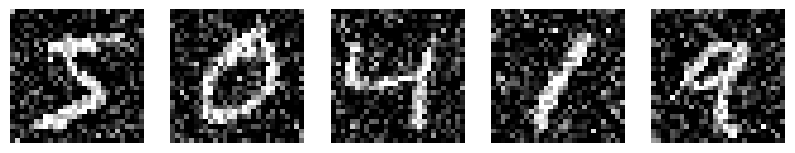

In [ ]:
plt.figure(figsize=(10, 2))
showImages(x_train_mnist_gau)
plt.show()

In [ ]:
# 10 Epochs
runModel(x_train_mnist_gau, x_train_mnist, x_test_mnist_gau, x_test_mnist, "Gaussian noise", optimizer="adam", epochs=10)

In [ ]:
# 25 Epochs
runModel(x_train_mnist_gau, x_train_mnist, x_test_mnist_gau, x_test_mnist, "Gaussian noise", optimizer="adam", epochs=25)

In [ ]:
# 35 Epochs
runModel(x_train_mnist_gau, x_train_mnist, x_test_mnist_gau, x_test_mnist, "Gaussian noise", optimizer="adam", epochs=35)

In [ ]:
# 50 Epochs with SGD optimizer
runModel(x_train_mnist_gau, x_train_mnist, x_test_mnist_gau, x_test_mnist, "Gaussian noise", optimizer="sgd")

Epoch 1/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.1264 - val_loss: 0.0755
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0752 - val_loss: 0.0741
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0741 - val_loss: 0.0734
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0737 - val_loss: 0.0733
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0735 - val_loss: 0.0734
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0732 - val_loss: 0.0731
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0730 - val_loss: 0.0728
Epoch 8/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0729 - val_loss: 0.0727
Epoch 9/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0729 - val_loss: 0.0732
Epoch 10/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0727 - val_loss: 0.0733
Epoch 11/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0725 - val_loss: 0.0726
Epoch 12/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9

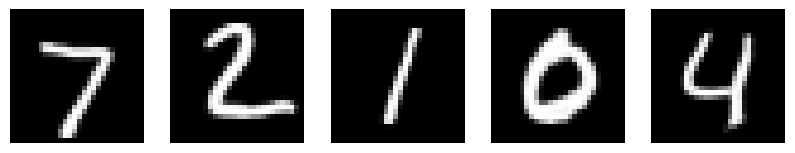


------------------------------------------------------------------------------------------

Original Image



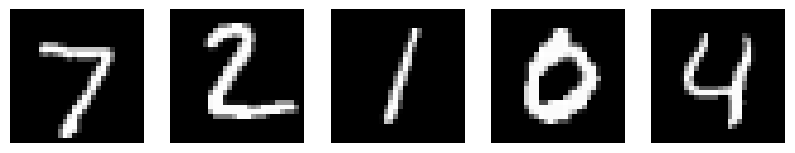

In [ ]:
# 50 Epochs with Adam optimizer and MSE loss
runModel(x_train_mnist_gau, x_train_mnist, x_test_mnist_gau, x_test_mnist, "Gaussian noise",optimizer="adam", loss="mse")

Salt & Pepper Noise

In [ ]:
# Add S&P noise to MNIST dataset

x_train_mnist_sp = add_salt_and_pepper_noise(x_train_mnist, 0.3)
x_test_mnist_sp = add_salt_and_pepper_noise(x_test_mnist, 0.3)


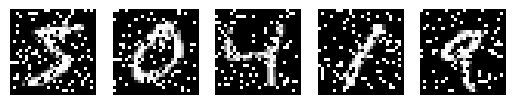

In [ ]:
showImages(x_train_mnist_sp)

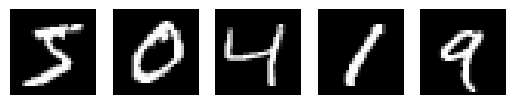

In [ ]:
showImages(x_train_mnist)

Epoch 1/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.1431 - val_loss: 0.0749
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0722 - val_loss: 0.0702
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0689 - val_loss: 0.0683
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0674 - val_loss: 0.0671
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0668 - val_loss: 0.0668
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0664 - val_loss: 0.0660
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0661 - val_loss: 0.0658
Epoch 8/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0657 - val_loss: 0.0657
Epoch 9/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0655 - val_loss: 0.0654
Epoch 10/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0651 - val_loss: 0.0653
Epoch 11/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0650 - val_loss: 0.0654
Epoch 12/50
938/938 ━━━━━━━━━━━━━━━━━━━━

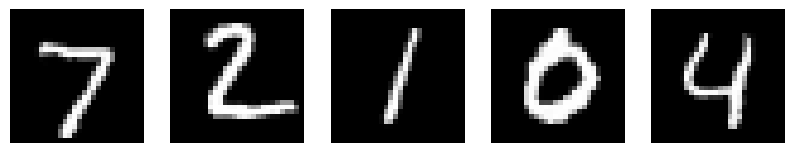


------------------------------------------------------------------------------------------

Original Image



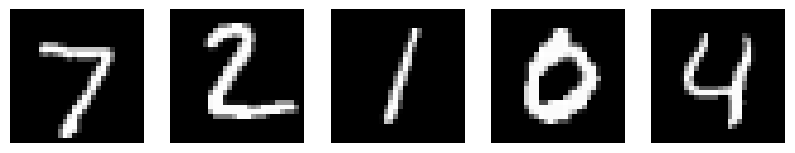

In [ ]:
# Build and compile the model
runModel(x_train_mnist_sp, x_train_mnist, x_test_mnist_sp, x_test_mnist, "S&P noise")

SPECKLE NOISE

In [ ]:
# Add Speckle noise to MNIST data
x_train_mnist_sk = add_speckle_noise(x_train_mnist, variance=0.3)
x_test_mnist_sk = add_speckle_noise(x_test_mnist, variance=0.3)

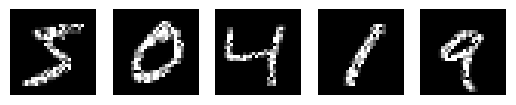

In [ ]:
showImages(x_train_mnist_sk)

Epoch 1/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.1171 - val_loss: 0.0693
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0690 - val_loss: 0.0693
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0677 - val_loss: 0.0670
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0672 - val_loss: 0.0668
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0669 - val_loss: 0.0666
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0668 - val_loss: 0.0664
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0667 - val_loss: 0.0663
Epoch 8/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0663 - val_loss: 0.0662
Epoch 9/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0662 - val_loss: 0.0661
Epoch 10/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0661 - val_loss: 0.0661
Epoch 11/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0660 - val_loss: 0.0660
Epoch 12/50
938/938 ━━━━━━━━━━━━━━━━━━

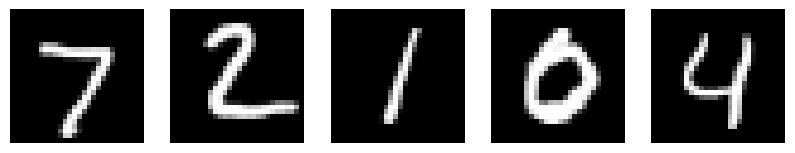


------------------------------------------------------------------------------------------

Original Image



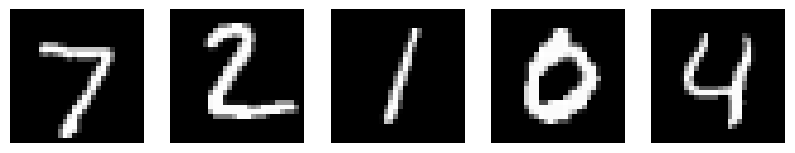

In [ ]:
runModel(x_train_mnist_sk, x_train_mnist, x_test_mnist_sk, x_test_mnist, "speckle noise")

Plot Variance/Amount vs PSNR result

In [ ]:
def plotResult (y, name):
  x = [0.08, 0.1, 0.15, 0.2, 0.3]
  plt.figure(figsize=(8, 4))
  plt.plot(x, y, marker='o', label='PSNR (dB)')
  plt.xlabel(f' {name} Amount')
  plt.ylabel('Average PSNR (dB)')
  plt.grid(True)
  plt.legend()
  plt.show()


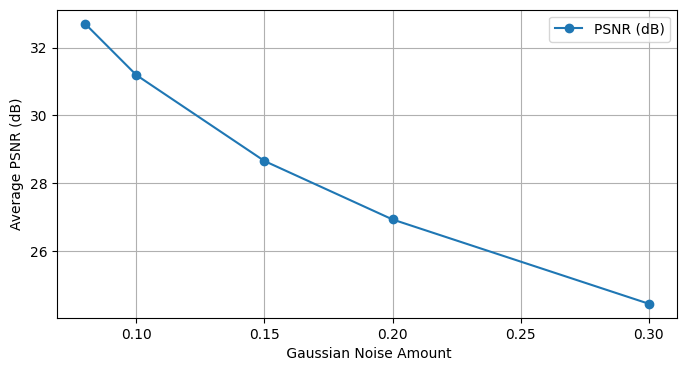

In [ ]:

gau_psnr = [32.70, 31.19, 28.66, 26.94, 24.46]
plotResult(gau_psnr, "Gaussian Noise")

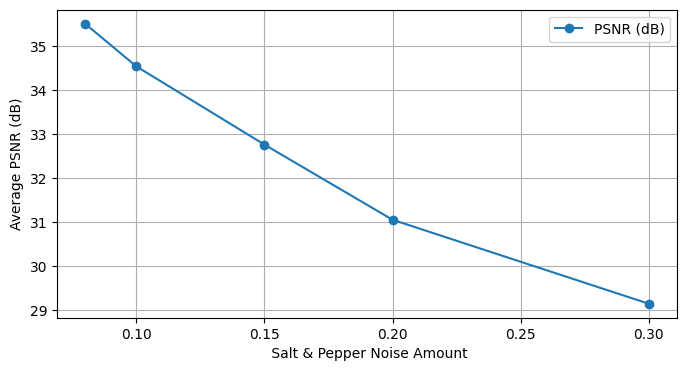

In [ ]:
sp_psnr = [35.51, 34.54, 32.76, 31.05, 29.14]
plotResult(sp_psnr, "Salt & Pepper Noise")

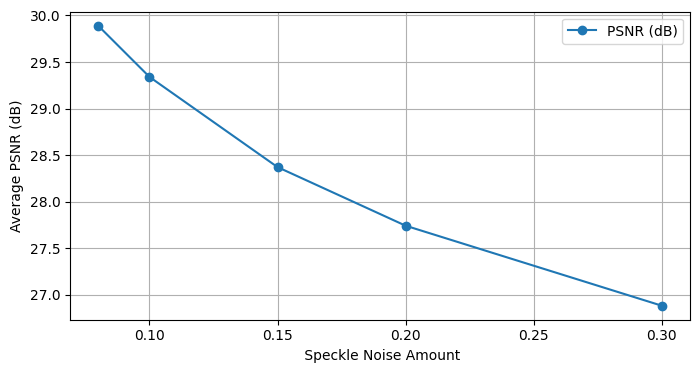

In [ ]:
s_psnr = [29.89, 29.34, 28.37, 27.74, 26.88]
plotResult(s_psnr, "Speckle Noise")

In [ ]:
def allPlotResult (gau, sp, s, name):
  x = [0.08, 0.1, 0.15, 0.2, 0.3]
  plt.figure(figsize=(8, 4))
  plt.plot(x,gau, marker='o', label='Gaussian Noise')
  plt.plot(x,sp, marker='s', label='Salt & Pepper Noise')
  plt.plot(x,s, marker='^', label='Speckle Noise')
  plt.xlabel('Noise Variance')
  plt.ylabel('Average PSNR (dB)')
  plt.title('PSNR Comparison Across Different Noise Types (MNIST)')
  plt.grid(True)
  plt.legend()
  plt.show()

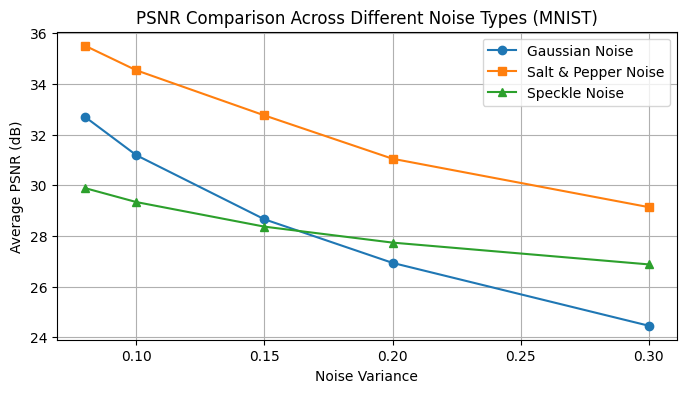

In [ ]:
allPlotResult(gau_psnr, sp_psnr, s_psnr, "MNIST")